# <font color='red'>1 - </font> Getting Data

In [1]:
path = "../dataset/data/"

In [2]:
import pandas as pd

df = pd.read_csv("../dataset/data/dataset-tickets-multi-lang3-4k.csv")

df = df.fillna('')

df.head()

,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Estamos investigando urgentemente el problema ...,Incident,Technical Support,high,es,IT Services,Urgent Issue,Service Disruption,Incident Report,Service Recovery,System Maintenance,,,,
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Product Support,Customer Service,Order Issue,Returns and Exchanges,,,,
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...","Prezado <name>,\n\nObrigado por entrar em cont...",Incident,Technical Support,high,pt,IT Services,Technical Support,Software Bug,Problem Resolution,Urgent Issue,IT Support,,,,
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...","Dear <name>,\n\nThank you for reaching out reg...",Request,IT Support,high,en,IT Services,IT Support,Urgent Issue,Service Notification,Cloud Services,Problem Resolution,Technical Guidance,Performance Tuning,,
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Product Support,low,fr,Tech Online Store,Technical Support,Product Support,Hardware Failure,Service Recovery,Routine Request,,,,


# <font color='red'>2 - </font> Data Analysis

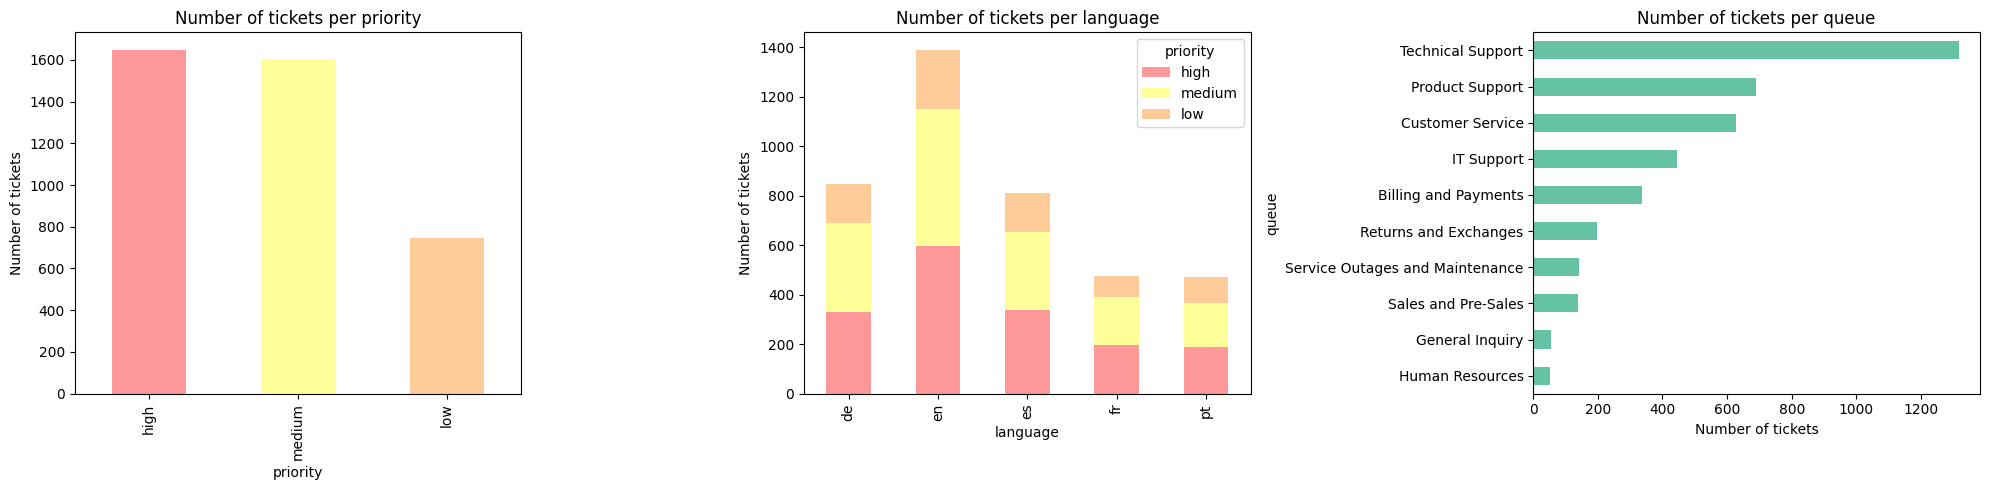

In [3]:
import matplotlib.pyplot as plt

def plot_distrib(df):
       fig, axs = plt.subplots(1, 3, figsize=(20, 5))

       counts = df['priority'].value_counts()[['high', 'medium', 'low']]
       counts.plot(kind="bar", stacked=True, color=['#ff9999', '#ffff99', '#ffcc99'], ax=axs[0])
       axs[0].set_title("Number of tickets per priority")
       axs[0].set_ylabel("Number of tickets")

       counts = df.groupby(['language', 'priority']).size().unstack(fill_value=0)
       counts[['high', 'medium', 'low']].plot(kind="bar", stacked=True,
                                          color=['#ff9999', '#ffff99', '#ffcc99'], ax=axs[1])
       axs[1].set_title("Number of tickets per language")
       axs[1].set_ylabel("Number of tickets")

       queues_order = ['Billing and Payments', 'Customer Service', 'General Inquiry',
              'Human Resources', 'IT Support', 'Product Support',
              'Returns and Exchanges', 'Sales and Pre-Sales',
              'Service Outages and Maintenance', 'Technical Support']

       counts = df['queue'].value_counts()[queues_order].sort_values(ascending=True)
       counts.plot(kind="barh", stacked=True, ax=axs[2], colormap="Set2")
       axs[2].set_title("Number of tickets per queue")
       axs[2].set_xlabel("Number of tickets")

       plt.tight_layout()
       plt.show()
plot_distrib(df)

In [4]:
df_copy = df.copy()
df_copy['combined_strata'] = df_copy['priority'] + '_' + df_copy['language'] + '_' + df_copy['queue']

In [131]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(len(df_copy)), random_state=42)

print(len(train_idx), len(test_idx))

3000 1000


In [132]:
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

In [135]:
samples = []
n_per_strata = 20
for strata_value, group in df_copy.iloc[train_idx].groupby('combined_strata'):
    if len(group) >= n_per_strata:
        sampled = group.sample(n=n_per_strata, random_state=42, replace=False)
    else:
        sampled = group.sample(n=n_per_strata, random_state=42, replace=True)
    samples.append(sampled)
    
balanced_df = pd.concat(samples).reset_index(drop=True)

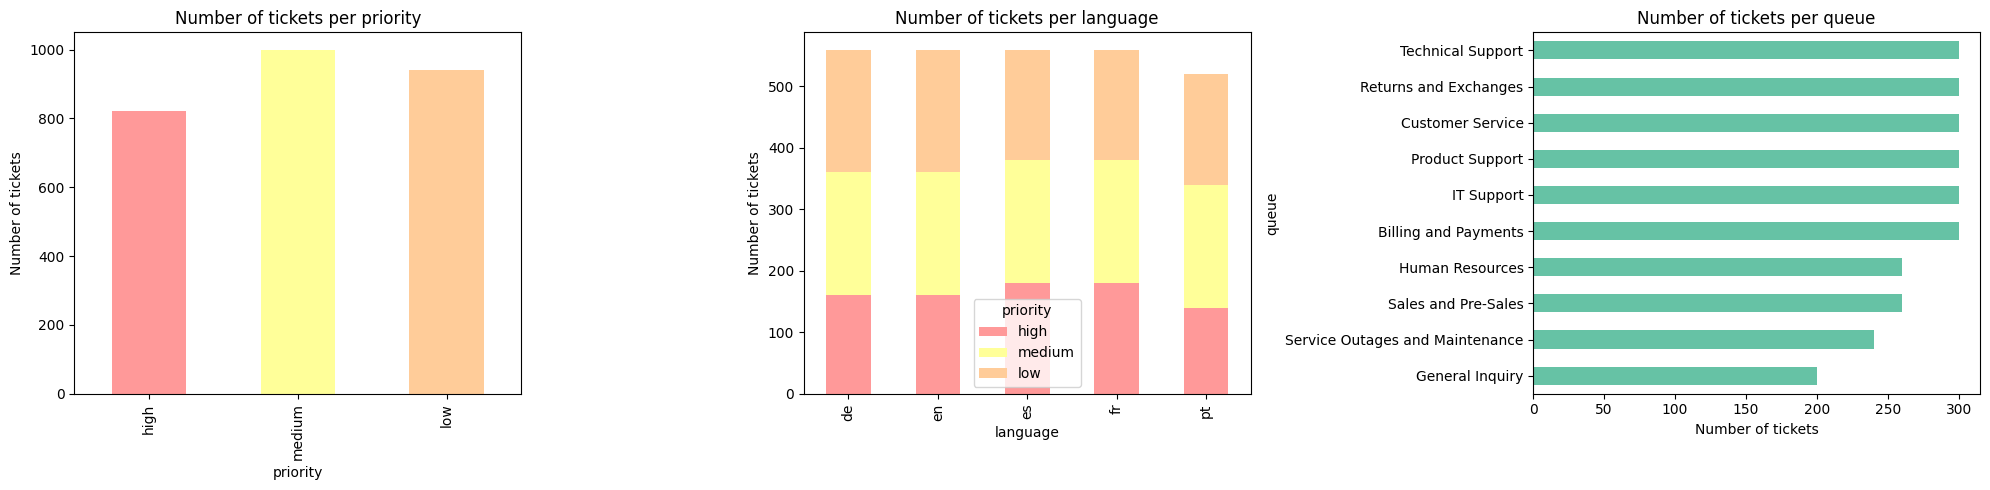

In [130]:
plot_distrib(balanced_df)

# <font color='red'>3 - </font> Prepare Data for Mistral Finetuning

In [136]:
import json

def write_training_data(output_file, balanced_df, idxs):

    with open(output_file, 'w', encoding='utf-8') as f:
        
        for idx in idxs:
            problem, priority, support_team, lg = balanced_df.iloc[idx][["body", "priority", "queue", "language"]]

            data = {
                "text": f"DESCRIPTION: {problem}",
                "labels": {
                    "support_team": support_team,
                    "priority": priority,
                    "lg": lg}
            }
            
            f.write(json.dumps(data, ensure_ascii=False) + '\n')

train_path = "../dataset/train_data_classification.jsonl"
val_path = "../dataset/val_data_classification.jsonl"
write_training_data(train_path, balanced_df, np.arange(len(balanced_df)))
write_training_data(val_path, df_copy, val_idx)

In [137]:
from mistralai import Mistral
import os

api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

In [138]:
def upload_dataset(path, name):
    return client.files.upload(
    file={
        "file_name": f"{name}",
        "content": open(f"{path}", "rb"),
    })

In [139]:
def get_data_id(name):
    files = client.files.list()
    for file in files.data:
        if file.filename == name:
            return file.id

In [140]:
upload_dataset(val_path, "validation_file_classification.jsonl")
upload_dataset(train_path, "train_data_classification.jsonl")

UploadFileOut(id='440b0d9b-c6fc-4ee4-8018-49373e91b6bb', object='file', size_bytes=2498892, created_at=1752229517, filename='train_data_classification.jsonl', purpose='fine-tune', sample_type='classification', source='upload', num_lines=2760)

In [141]:
val_id = get_data_id("validation_file_classification.jsonl")
train_id = get_data_id("train_data_classification.jsonl")

In [164]:
def create_job(val_id, train_id):
    wandb_key = os.environ["WANDB_KEY"]

    return client.fine_tuning.jobs.create(
        model="ministral-3b-latest",
        job_type="classifier",
        training_files=[{"file_id": train_id, "weight": 1}],
        validation_files=[val_id],
        hyperparameters={
            "training_steps": 200,
            "learning_rate":0.0001
        },
        integrations=[
            {
                "project": "ticket_classifier",
                "api_key": wandb_key,
            }
            ],
        auto_start=False,
        )
create_job(val_id, train_id)

ClassifierJobOut(id='3a490782-424a-419d-aa1f-d7606e972519', auto_start=False, model='ministral-3b-latest', status='QUEUED', created_at=1752259834, modified_at=1752259834, training_files=['af31d7c9-a085-41f0-9739-0d3d529ff654'], hyperparameters=ClassifierTrainingParameters(training_steps=200, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.05, epochs=None, seq_len=16384), validation_files=['c5bfb578-14fa-4115-8166-59c943f839f3'], object='job', fine_tuned_model=None, suffix=None, integrations=[WandbIntegrationOut(project='ticket_classifier', type='wandb', name=None, run_name=None, url=None)], trained_tokens=None, metadata=JobMetadataOut(expected_duration_seconds=None, cost=0.0, cost_currency=None, train_tokens_per_step=None, train_tokens=None, data_tokens=None, estimated_start_time=None), job_type='classifier')

# <font color='red'>4 - </font> Testing the finetuned Classifier

In [ ]:
last_model = "ft:classifier:ministral-3b-latest:7e530b29:20250711:3a490782"

SyntaxError: invalid decimal literal (166268246.py, line 1)

In [161]:
from tqdm import tqdm

ref_priority, ref_support_team = [], []
pred_priority, pred_support_team = [], []

for test in tqdm(range(len(test_idx))):
    ticket_sample_problem = df_copy.iloc[test_idx[test]]['body']

    classifier_response = client.classifiers.classify(
    model=last_model,
    inputs=[f"DESCRIPTION: {ticket_sample_problem}"])

    pred_priority.append(max(classifier_response.results[0]['priority'].scores.items(), key=lambda x:x[1])[0])
    pred_support_team.append(max(classifier_response.results[0]['support_team'].scores.items(), key=lambda x:x[1])[0])

    ref_priority.append(df_copy.iloc[test_idx[test]]['priority'])
    ref_support_team.append(df_copy.iloc[test_idx[test]]['queue'])

100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


# <font color='red'>5 - </font> Metrics for Classification

In [162]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_ref_priority = label_encoder.fit_transform(ref_priority)
encoded_pred_priority = label_encoder.transform(pred_priority)

label_encoder = LabelEncoder()
encoded_ref_support_team = label_encoder.fit_transform(ref_support_team)
encoded_pred_support_team = label_encoder.transform(pred_support_team)


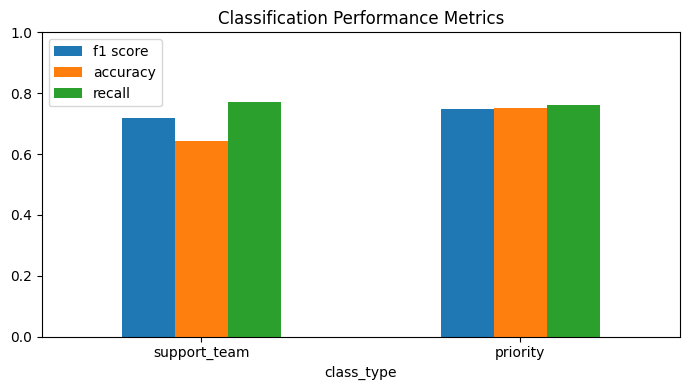

In [163]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

df_score = pd.DataFrame(
    {
        "class_type" : ["support_team", "priority"],
        "f1 score" : [f1_score(encoded_ref_support_team, encoded_pred_support_team, average="macro"),
                      f1_score(encoded_ref_priority, encoded_pred_priority, average="macro")],

        "accuracy" : [accuracy_score(encoded_ref_support_team, encoded_pred_support_team),
                      accuracy_score(encoded_ref_priority, encoded_pred_priority)],

        "recall" : [recall_score(encoded_ref_support_team, encoded_pred_support_team, average="macro"),
                    recall_score(encoded_ref_priority, encoded_pred_priority, average="macro")]
    }
)

df_score.plot(x='class_type', y=['f1 score', 'accuracy', 'recall'], kind='bar', figsize=(7, 4))
plt.title("Classification Performance Metrics")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.tight_layout()